In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, isnan, when, count, sum
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer

spark = SparkSession.builder.appName("KMeansClustering").config("spark.hadoop.hadoop.home.dir", "C:/Hadoop").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/11/12 22:03:53 WARN Utils: Your hostname, LAPTOP-75KMQ53F resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/11/12 22:03:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/12 22:03:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/12 22:03:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/11/12 22:03:54 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
dataset_path = '../dataset/udemy_courses_dataset.csv'

data = spark.read.csv(dataset_path, header=True)

In [3]:
data.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|  content_duration| published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|           2147|         23|          51|        All Levels|               1.5|2017-01-18T20:58:58Z|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|           2792|        923|         274|        All Levels|              39.0|2017-03-09T16:34:20Z|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|   True|   45|        

In [4]:
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+
|course_id|course_title|url|is_paid|price|num_subscribers|num_reviews|num_lectures|level|content_duration|published_timestamp|subject|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+
|        0|           0|  0|      0|    0|              0|          0|           0|    0|               0|                  0|      5|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+



In [5]:
# Menampilkan schema dfFrame
data.printSchema()

root
 |-- course_id: string (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: string (nullable = true)
 |-- price: string (nullable = true)
 |-- num_subscribers: string (nullable = true)
 |-- num_reviews: string (nullable = true)
 |-- num_lectures: string (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: string (nullable = true)
 |-- published_timestamp: string (nullable = true)
 |-- subject: string (nullable = true)



In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Cast columns to float to ensure they are numeric
data = data.withColumn("num_subscribers", col("num_subscribers").cast("float"))
data = data.withColumn("num_reviews", col("num_reviews").cast("float"))
data = data.withColumn("num_lectures", col("num_lectures").cast("float"))
data = data.withColumn("content_duration", col("content_duration").cast("float"))

# Drop rows with NaN values in the specific columns used by the model
data = data.dropna()

# Ensure previous feature columns do not exist to prevent conflicts
if "features_unscaled" in data.columns:
    data = data.drop("features_unscaled")
if "features" in data.columns:
    data = data.drop("features")

# Assemble features with columns specific to API 2
assembler = VectorAssembler(inputCols=["num_subscribers", "num_reviews", "num_lectures", "content_duration"], 
                            outputCol="features_unscaled")
data = assembler.transform(data)

# Display the transformed data for debugging
data.show()


+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration| published_timestamp|         subject|   features_unscaled|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|         2147.0|       23.0|        51.0|        All Levels|             1.5|2017-01-18T20:58:58Z|Business Finance|[2147.0,23.0,51.0...|
|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|         2792.0|      923.0|       274.0|        All Levels|            39.0|2017-03-09T16:34:20Z|Business Finance|[2

In [7]:
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+-----------------+
|course_id|course_title|url|is_paid|price|num_subscribers|num_reviews|num_lectures|level|content_duration|published_timestamp|subject|features_unscaled|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+-----------------+
|        0|           0|  0|      0|    0|              0|          0|           0|    0|               0|                  0|      0|                0|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+-----------------+



In [8]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data.select("features_unscaled", "features").show()

+--------------------+--------------------+
|   features_unscaled|            features|
+--------------------+--------------------+
|[2147.0,23.0,51.0...|[0.22590210091500...|
|[2792.0,923.0,274...|[0.29376742699333...|
|[2174.0,74.0,51.0...|[0.22874297502991...|
|[2451.0,11.0,36.0...|[0.25788823909766...|
|[1276.0,45.0,26.0...|[0.13425760631930...|
|[9221.0,138.0,25....|[0.97021111902062...|
|[1540.0,178.0,26....|[0.16203504210950...|
|[2917.0,148.0,23....|[0.30691962196975...|
|[5172.0,34.0,38.0...|[0.54418521934439...|
|[827.0,14.0,15.0,...|[0.08701492196400...|
|[4284.0,93.0,76.0...|[0.45075202623189...|
|[1380.0,42.0,17.0...|[0.14520023253968...|
|[3607.0,21.0,19.0...|[0.37951973823960...|
|[4061.0,52.0,16.0...|[0.42728851039396...|
|[294.0,19.0,42.0,...|[0.03093396258454...|
|[2276.0,106.0,19....|[0.23947516613067...|
|[4919.0,79.0,16.0...|[0.51756517671211...|
|[2666.0,115.0,52....|[0.28051001445710...|
|[5354.0,24.0,23.0...|[0.56333481523006...|
|[8095.0,249.0,12....|[0.8517361

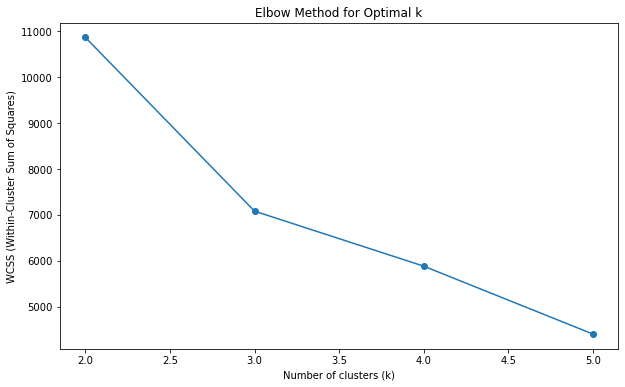

In [9]:
wcss = []

for k in range(2, 6):
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(data)

    wcss.append(model.summary.trainingCost)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 6), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [10]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Define the function to find optimal k using silhouette score
def find_optimal_k(data, max_k=10):
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(featuresCol="features", k=k, seed=1, maxIter=100, initSteps=10)
        model = kmeans.fit(data)
        predictions = model.transform(data)
        
        evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
        silhouette = evaluator.evaluate(predictions)
        silhouette_scores.append((k, silhouette))
        print(f"k: {k}, Silhouette Score: {silhouette}")
    
    best_k = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f"\nOptimal k berdasarkan Silhouette Score adalah: {best_k}")
    
    return best_k, silhouette_scores

# Determine optimal k
best_k, silhouette_scores = find_optimal_k(data, max_k=5)

# Train the final model using the best k
kmeans = KMeans(featuresCol="features", k=best_k, seed=1, maxIter=100, initSteps=10)
model = kmeans.fit(data)
data = model.transform(data)

# Evaluate the final model using silhouette score
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(data)
print(f"\nSilhouette Score untuk model dengan k={best_k}: {silhouette}")

# Group by prediction and calculate averages of available numeric columns
data.groupBy("prediction").avg("num_subscribers", "num_reviews", "num_lectures", "content_duration").show()


k: 2, Silhouette Score: 0.9311453206411286
k: 3, Silhouette Score: 0.9101666035574724
k: 4, Silhouette Score: 0.7536571753482858
k: 5, Silhouette Score: 0.7697149449827047

Optimal k berdasarkan Silhouette Score adalah: 2

Silhouette Score untuk model dengan k=2: 0.9311453206411286
+----------+--------------------+-----------------+------------------+---------------------+
|prediction|avg(num_subscribers)| avg(num_reviews)| avg(num_lectures)|avg(content_duration)|
+----------+--------------------+-----------------+------------------+---------------------+
|         1|  25586.545454545456|2205.560606060606|209.96212121212122|   24.893939393939394|
|         0|  2363.7044557247605|79.97377326565145| 33.78595600676819|    3.320257567381933|
+----------+--------------------+-----------------+------------------+---------------------+



In [11]:
model.save("spark_kmeans_model_c")

print("Model saved to spark_kmeans_model")

Model saved to spark_kmeans_model
